<a href="https://colab.research.google.com/github/Farmhouse121/Essays-on-Trading-Strategy/blob/main/Money_Left_on_the_Table_for_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Installing yfinance and arch and getting the data...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from warnings import filterwarnings ; filterwarnings('ignore',category=FutureWarning) # I don't care
from yfinance import download,Ticker
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from statsmodels.regression.linear_model import OLS
from statsmodels.api import add_constant
from arch.univariate import ARX, GARCH, GeneralizedError
from datetime import datetime
from scipy.optimize import minimize
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
from matplotlib.ticker import Formatter

class IntegerFormatter(Formatter):
     """Class to format axis as integers."""

     def __call__(self,data,pos=None):
        return "{:,.0f}".format(data)

zero,one,two,four,three,five,ten,hundred,annualize=0e0,1e0,2e0,3e0,4e0,5e0,1e1,1e2,252e0 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# get the daily returns from Yahoo! Finance
ticker='SPY'
data=download(ticker,'2018-12-31','2021-12-31')         # get prices
data.index=pd.DatetimeIndex(data.index).to_period('B')  # set calendar to business days
data['Return']=data['Adj Close'].pct_change()*hundred   # compute returns including splits, dividends etc. https://help.yahoo.com/kb/adjusted-close-sln28256.html
data['LagReturn']=data['Return'].shift()                # compute returns lagged by one trading day
data.dropna(inplace=True)                               # remove any dates that are not properly 'bars', often due to holidays not properly removed
data.loc[data["Volume"]==0,"Volume"]=np.nan             # change zero volume to NA should it exist
data

Installing yfinance and arch and getting the data...
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn
Date,,,,,,,,
2019-01-03,248.229996,248.570007,243.669998,244.210007,228.476227,144140700.0,-2.386302,0.104043
2019-01-04,247.589996,253.110001,247.169998,252.389999,236.129242,142628800.0,3.349589,-2.386302
2019-01-07,252.690002,255.949997,251.690002,254.380005,237.991013,103139100.0,0.788454,3.349589
2019-01-08,256.820007,257.309998,254.000000,256.769989,240.227036,102512600.0,0.939541,0.788454
2019-01-09,257.559998,258.910004,256.190002,257.970001,241.349716,95006600.0,0.467342,0.939541
...,...,...,...,...,...,...,...,...
2021-12-23,468.750000,472.190002,468.640015,470.600006,463.087189,56439700.0,0.622203,0.999872
2021-12-27,472.059998,477.309998,472.010010,477.260010,469.640869,56808600.0,1.415215,0.622203
2021-12-28,477.720001,478.809998,476.059998,476.869995,469.257080,47274600.0,-0.081720,1.415215


In [2]:
print("Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...\n")
model = ARX(data["Return"],lags=1)
model.volatility = GARCH(1, 1, 1)
model.distribution = GeneralizedError()
ged_model=model.fit(update_freq=0)
print(ged_model.summary())
print("IC = %g." % np.sqrt(ged_model.rsquared))

# save alpha
data["Alpha"]=ged_model.params[0]+ged_model.params[1]*data["LagReturn"]
data["Volatility"]=ged_model.conditional_volatility
data["ScaledAlpha"]=data["Alpha"]/data["Volatility"]
data

Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...

Optimization terminated successfully    (Exit mode 0)
            Current function value: 983.3892476391654
            Iterations: 16
            Function evaluations: 146
            Gradient evaluations: 16
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.039
Mean Model:                                    AR   Adj. R-squared:                  0.038
Vol Model:                              GJR-GARCH   Log-Likelihood:               -983.389
Distribution:      Generalized Error Distribution   AIC:                           1980.78
Method:                        Maximum Likelihood   BIC:                           2013.16
                                                    No. Observations:                  754
Date:                            Tue, Feb 28 2023   Df Residuals:          

,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn,Alpha,Volatility,ScaledAlpha
Date,,,,,,,,,,,
2019-01-03,248.229996,248.570007,243.669998,244.210007,228.476227,144140700.0,-2.386302,0.104043,0.128427,NaN,NaN
2019-01-04,247.589996,253.110001,247.169998,252.389999,236.129242,142628800.0,3.349589,-2.386302,0.349983,1.017009,0.344130
2019-01-07,252.690002,255.949997,251.690002,254.380005,237.991013,103139100.0,0.788454,3.349589,-0.160317,1.335345,-0.120057
2019-01-08,256.820007,257.309998,254.000000,256.769989,240.227036,102512600.0,0.939541,0.788454,0.067537,1.176892,0.057386
2019-01-09,257.559998,258.910004,256.190002,257.970001,241.349716,95006600.0,0.467342,0.939541,0.054095,1.046768,0.051679
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,468.750000,472.190002,468.640015,470.600006,463.087189,56439700.0,0.622203,0.999872,0.048728,1.151858,0.042304
2021-12-27,472.059998,477.309998,472.010010,477.260010,469.640869,56808600.0,1.415215,0.622203,0.082328,1.003502,0.082041
2021-12-28,477.720001,478.809998,476.059998,476.869995,469.257080,47274600.0,-0.081720,1.415215,0.011777,0.974900,0.012080


,,Sample,Mean,StDev,Kurtosis,Sharpe,StdErr
Strategy,Ticker,,,,,,
Buy and Hold,SPY,755.0,0.101581,1.381626,19.707841,1.167141,0.587389
Markowitz/Kelly,SPY,754.0,0.018226,0.182912,10.541657,1.581818,0.587173
Sign of Alpha,SPY,755.0,0.189701,1.372293,19.504089,2.194438,0.610832


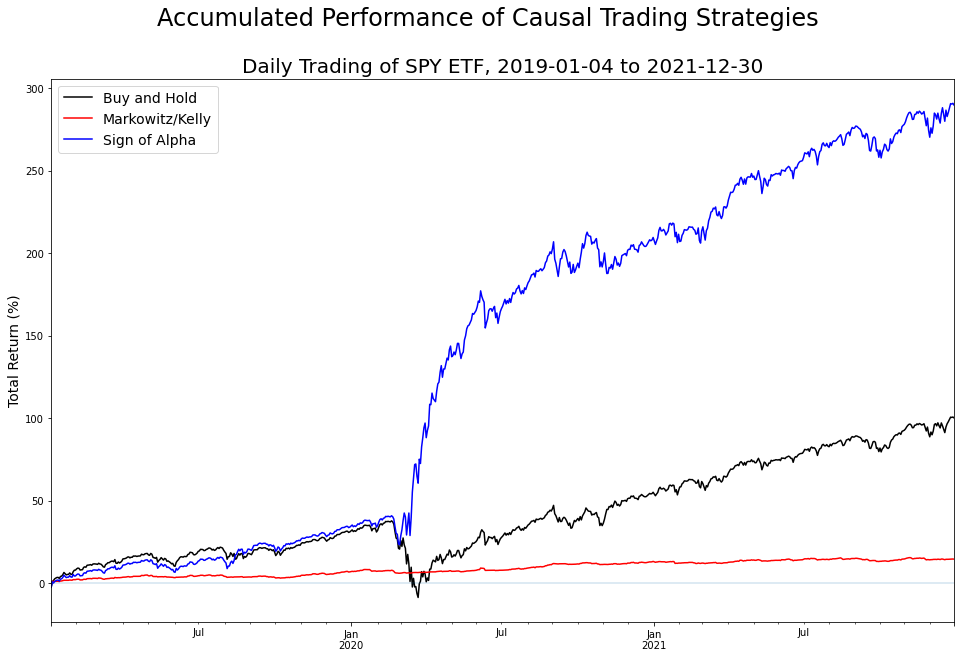

In [3]:
# score performance for various strategies
stats=pd.DataFrame({'Strategy':[],'Ticker':[],'Sample':[],'Mean':[],'StDev':[],'Kurtosis':[],'Sharpe':[],'StdErr':[]}).set_index(['Strategy','Ticker'])

figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))

strategy='Buy and Hold'
data["Holding"]=one
data["Profit"]=data["Holding"]*data["Return"]
stats=stats.append(pd.DataFrame({
        "Strategy":[strategy],
        "Ticker":[ticker],
        "Sample":[data["Profit"].count()],
        "Mean":[data["Profit"].mean()],
        "StDev":[data["Profit"].std()],
        "Kurtosis":[data["Profit"].kurt()+three],
        }).set_index(["Strategy","Ticker"]))

(np.exp(np.log(one+data["Profit"]/hundred).cumsum())*hundred-hundred).plot(ax=plot,label=strategy,color='black')

strategy='Markowitz/Kelly'
data["Holding"]=(data["Alpha"]/data["Volatility"]**two)
data["Profit"]=data["Holding"]*data["Return"]
stats=stats.append(pd.DataFrame({
        "Strategy":[strategy],
        "Ticker":[ticker],
        "Sample":[data["Profit"].count()],
        "Mean":[data["Profit"].mean()],
        "StDev":[data["Profit"].std()],
        "Kurtosis":[data["Profit"].kurt()+three],
        }).set_index(["Strategy","Ticker"]))

(np.exp(np.log(one+data["Profit"]/hundred).cumsum())*hundred-hundred).plot(ax=plot,label=strategy,color='red')

strategy='Sign of Alpha'
data["Holding"]=np.sign(data["Alpha"])
data["Profit"]=data["Holding"]*data["Return"]
stats=stats.append(pd.DataFrame({
        "Strategy":[strategy],
        "Ticker":[ticker],
        "Sample":[data["Profit"].count()],
        "Mean":[data["Profit"].mean()],
        "StDev":[data["Profit"].std()],
        "Kurtosis":[data["Profit"].kurt()+three],
        }).set_index(["Strategy","Ticker"]))

(np.exp(np.log(one+data["Profit"]/hundred).cumsum())*hundred-hundred).plot(ax=plot,label=strategy,color='blue')

plot.legend(fontsize=14)
plot.axhline(alpha=0.2)
plot.set_ylabel("Total Return (%)",fontsize=14)
plot.set_xlabel(None)
figure.suptitle("Accumulated Performance of Causal Trading Strategies",fontsize=24)
plot.set_title("Daily Trading of SPY ETF, %s to %s" % (data.index[1],data.index[-1]),fontsize=20)
figure.savefig('essay6_performance.png',dpi=300,bbox_inches='tight')

stats["Sharpe"]=stats["Mean"]/stats["StDev"]*np.sqrt(annualize) # yeah, no risk free rate but its basically been zero for this entire period, 252 trading days per year in US
stats["StdErr"]=np.sqrt(annualize/stats["Sample"]*(one+(stats["Kurtosis"]-one)/(four*annualize)*stats["Sharpe"]**2)) # standard error of Sharpe Ratio with kurtosis
stats

Max Gross Profit Optimizer for SPY...



,,Sample,Mean,StDev,Kurtosis,Sharpe,StdErr
Strategy,Ticker,,,,,,
Buy and Hold,SPY,755.0,0.101581,1.381626,19.707841,1.167141,0.587389
Markowitz/Kelly,SPY,754.0,0.018226,0.182912,10.541657,1.581818,0.587173
Sign of Alpha,SPY,755.0,0.189701,1.372293,19.504089,2.194438,0.610832
Max Gross Profit,SPY,755.0,0.843307,1.098687,30.228908,12.184627,1.499886


Holding,Short,Long
OptimalHolding,,
Short,27,287
Long,16,425


Precision: 59.7%; Recall: 96.4%; Accuracy 59.9%; F1 Score 73.7%.


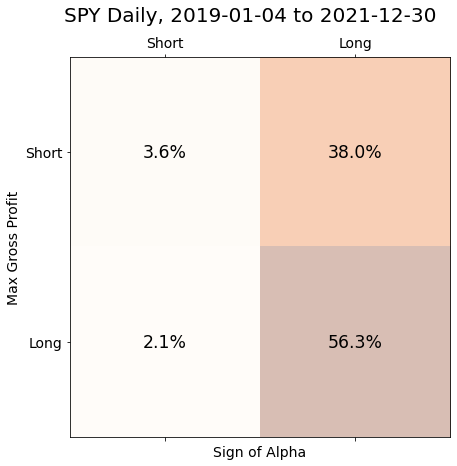

In [4]:
strategy="Max Gross Profit"
print("%s Optimizer for %s...\n" % (strategy,ticker))

def objective(holding):
    """Objective function for minimization."""
    return -sum(data["Return"]*holding)

solution=minimize(objective,np.sign(data["Alpha"]),bounds=[(-one,one)]*len(data["Alpha"]))

if solution.status:
    raise ValueError("Optimization ended with status %d." % solution.status)

else:
    data["OptimalHolding"]=solution.x
    data["OptimalProfit"]=data["OptimalHolding"]*data["Return"]
    stats=stats.append(pd.DataFrame({
        "Strategy":[strategy],
        "Ticker":[ticker],
        "Sample":[data["OptimalProfit"].count()],
        "Mean":[data["OptimalProfit"].mean()],
        "StDev":[data["OptimalProfit"].std()],
        "Kurtosis":[data["OptimalProfit"].kurt()+three],
        }).set_index(["Strategy","Ticker"])).drop_duplicates()

stats["Sharpe"]=stats["Mean"]/stats["StDev"]*np.sqrt(annualize) # yeah, no risk free rate but its basically been zero for this entire period, 252 trading days per year in US
stats["StdErr"]=np.sqrt(annualize/stats["Sample"]*(one+(stats["Kurtosis"]-one)/(four*annualize)*stats["Sharpe"]**2)) # standard error of Sharpe Ratio with kurtosis
display(stats)

figure,plot=pl.subplots(figsize=(7*GoldenRatio,7))
confusion=pd.crosstab(data["OptimalHolding"].apply(lambda x:"Long" if x>0 else "Short" if x<0 else "Flat"),
                      data["Holding"].apply(lambda x:"Long" if x>0 else "Short" if x<0 else "Flat")).iloc[[1,0],[1,0]]
display(confusion)
print("Precision: %.1f%%; Recall: %.1f%%; Accuracy %.1f%%; F1 Score %.1f%%." % (
    precision_score(y_true=data["OptimalHolding"],y_pred=data["Holding"])*hundred,
    recall_score(y_true=data["OptimalHolding"],y_pred=data["Holding"])*hundred,
    accuracy_score(y_true=data["OptimalHolding"],y_pred=data["Holding"])*hundred,
    f1_score(y_true=data["OptimalHolding"],y_pred=data["Holding"])*hundred
))
plot.matshow(confusion,cmap=pl.cm.Oranges,alpha=0.3)

for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plot.text(x=j,y=i,s="%.1f%%" % (confusion.iloc[i,j]*hundred/confusion.sum().sum()),va='center', ha='center', size='xx-large')
 
plot.set_xlabel('Sign of Alpha', fontsize=14)
plot.set_xticks([0,1]) ; plot.set_xticklabels(list(confusion.index),fontsize=14)
plot.set_ylabel('Max Gross Profit',fontsize=14)
plot.set_yticks([0,1]) ; plot.set_yticklabels(list(confusion.index),fontsize=14)
figure.suptitle("%s Daily, %s to %s" % (ticker,data.index[1],data.index[-1]),fontsize=20)
title="Confusion Matrix for %s" % ticker
#figure.suptitle(title, fontsize=22)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

Optimization terminated successfully.
         Current function value: 0.674032
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         OptimalHolding   No. Observations:                  755
Model:                          Logit   Df Residuals:                      753
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Feb 2023   Pseudo R-squ.:                0.007217
Time:                        15:06:14   Log-Likelihood:                -508.89
converged:                       True   LL-Null:                       -512.59
Covariance Type:            nonrobust   LLR p-value:                  0.006527
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1226      0.110      1.110      0.267      -0.094       0.339
Alpha          1.7177      0.

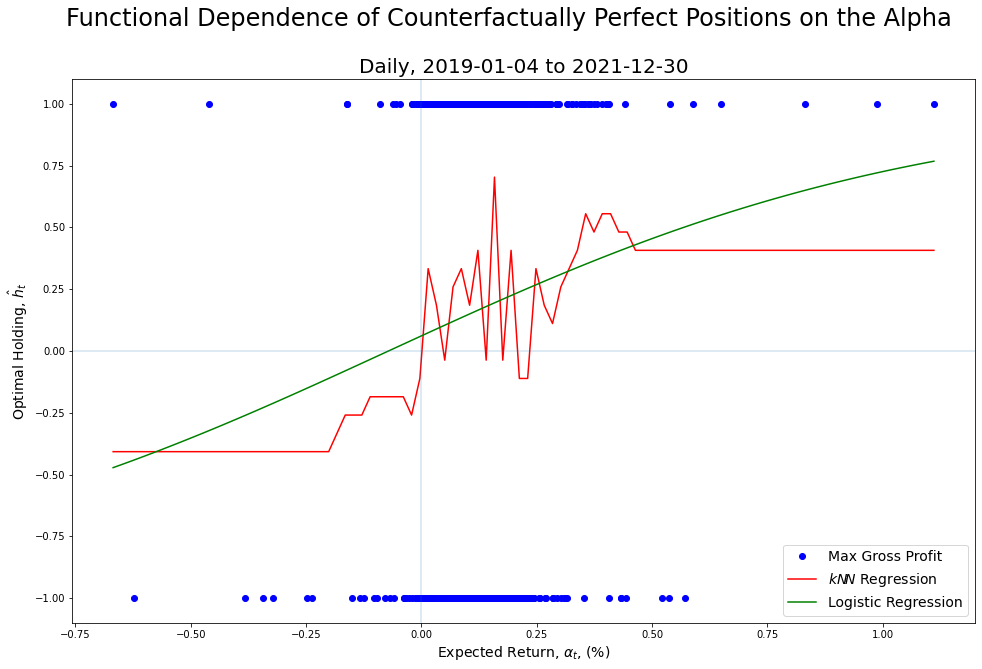

In [5]:
from sklearn.neighbors import KNeighborsRegressor as KNN
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
target,description,latex='Alpha','Alpha','\\alpha_t'
#target,description,latex='ScaledAlpha','Scaled Alpha','\\alpha_t/\\sigma_t'
design=data[[target,"OptimalHolding"]].dropna()
model=KNN(int(np.sqrt(design.shape[0]))).fit(np.array(design[target]).reshape((design.shape[0],1)),design["OptimalHolding"])
x=np.linspace(min(design[target]),max(design[target]),100)
y=model.predict(x.reshape((x.shape[0],1)))
lrmodel=Logit(design["OptimalHolding"]>zero,add_constant(design[target])).fit()
print(lrmodel.summary())
z=lrmodel.predict(add_constant(x))*two-one

figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
plot.plot(design[target],design["OptimalHolding"],'bo',label='Max Gross Profit')
plot.plot(x,y,'r-',label='$kN\!N$ Regression')
plot.plot(x,z,'g-',label='Logistic Regression')
plot.set_xlabel("Expected Return, $%s$, (%%)" % latex,fontsize=14)
plot.set_ylabel("Optimal Holding, $\\hat{h}_t$",fontsize=14)
plot.legend(fontsize=14)
plot.axhline(alpha=0.2)
plot.axvline(alpha=0.2)
figure.suptitle("Functional Dependence of Counterfactually Perfect Positions on the %s" % description,fontsize=24)
plot.set_title("Daily, %s to %s" % (data.index[1],data.index[-1]),fontsize=20)
figure.savefig("essay6_%s.png" % ("knn" if target=='Alpha' else 'knn2'),dpi=300,bbox_inches='tight')
pass

In [6]:
strategy="Mean-Variance Optimal"
print("%s Optimizer for %s...\n" % (strategy,ticker))

def objective(holding):
    """Objective function for minimization."""
    pnl=holding*data["Return"]
    return -(pnl.mean()-half*pnl.var())

solution=minimize(objective,np.sign(data["Alpha"]),bounds=[(-one,one)]*len(data["Alpha"]),options={"maxfun":1000000})

if solution.status:
    raise ValueError("Optimization ended with status %d.\n%s" % (solution.status,solution.message))

else:
    data["OptimalHolding"]=solution.x
    data["OptimalProfit"]=data["OptimalHolding"]*data["Return"]
    stats=stats.append(pd.DataFrame({
        "Strategy":[strategy],
        "Ticker":[ticker],
        "Sample":[data["OptimalProfit"].count()],
        "Mean":[data["OptimalProfit"].mean()],
        "StDev":[data["OptimalProfit"].std()],
        "Kurtosis":[data["OptimalProfit"].kurt()+three],
        }).set_index(["Strategy","Ticker"]))

stats["Sharpe"]=stats["Mean"]/stats["StDev"]*np.sqrt(annualize) # yeah, no risk free rate but its basically been zero for this entire period, 252 trading days per year in US
stats["StdErr"]=np.sqrt(annualize/stats["Sample"]*(one+(stats["Kurtosis"]-one)/(four*annualize)*stats["Sharpe"]**2)) # standard error of Sharpe Ratio with kurtosis
stats

Mean-Variance Optimal Optimizer for SPY...



,,Sample,Mean,StDev,Kurtosis,Sharpe,StdErr
Strategy,Ticker,,,,,,
Buy and Hold,SPY,755.0,0.101581,1.381626,19.707841,1.167141,0.587389
Markowitz/Kelly,SPY,754.0,0.018226,0.182912,10.541657,1.581818,0.587173
Sign of Alpha,SPY,755.0,0.189701,1.372293,19.504089,2.194438,0.610832
Max Gross Profit,SPY,755.0,0.843307,1.098687,30.228908,12.184627,1.499886
Mean-Variance Optimal,SPY,755.0,0.683958,0.530605,3.162377,20.462505,0.856457


<ipython-input-7-eba65b36dab3>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(list(zip(*list(stats.index)))[0],fontsize=14)


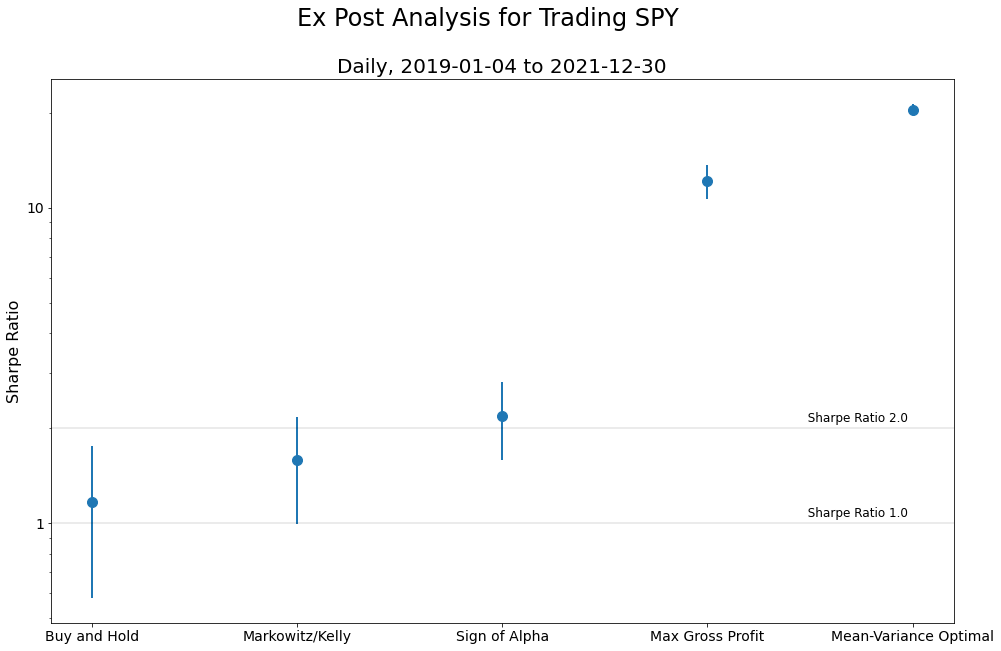

In [7]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
title="Ex Post Analysis for Trading %s" % ticker
figure.suptitle(title,fontsize=24)
plot.errorbar(list(zip(*list(stats.index)))[0],stats["Sharpe"],yerr=stats["StdErr"],fmt='o',linewidth=2,markersize=10)
plot.set_title("Daily, %s to %s" % (data.index[1],data.index[-1]),fontsize=20)
plot.set_xlabel(None);
plot.set_ylabel("Sharpe Ratio",fontsize=16)
#plot.set_xlabel("Strategy",fontsize=16)
plot.set_xlabel(None)
plot.axhline(one,color='black',alpha=0.1)
plot.axhline(two,color='black',alpha=0.1)
plot.set_yscale('log')
plot.set_xticklabels(list(zip(*list(stats.index)))[0],fontsize=14)
plot.text("Max Gross Profit",1.05,"                          Sharpe Ratio 1.0",fontsize=12)
plot.text("Max Gross Profit",2.10,"                          Sharpe Ratio 2.0",fontsize=12)
plot.yaxis.set_major_formatter(IntegerFormatter())
pl.tick_params(axis='y',which='major',labelsize=14)
figure.savefig("essay6_sharpes.png",dpi=300,bbox_inches='tight');